# Toxic Comment Classification 

### Introduction & Objective
This is a Kaggle competition held by the Conversation AI team, Conversation AI team is dedicated to helping improve online conversation at scale. The goal of this competition is to identify and classify toxic online comments from Wikipedia’s talk page edits by building a multi-headed model that’s capable of detecting different types of toxicity. Information about this competition and Conversation AI team:
- Kaggle: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
- Conversation AI team: https://conversationai.github.io/

### Data Overview
The dataset is from Wikipedia comments and have been labeled by human raters for toxic behavior. The training data has 8 columns, including id, comments, and 6 different types of toxicity. The test data has id and comments, the goal is to predict the probability of each type of toxicity for each comment on the test data set.
The toxicity types of comments are,
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate



In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize
import re
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

### Looking at the Data

#### Import the data

In [2]:
trainDF = pd.read_csv('train.csv')
print(trainDF.shape)


(159571, 8)


In [3]:
trainDF.head(10)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [4]:
testDF = pd.read_csv('test.csv')
print(testDF.shape)


(153164, 2)


In [24]:
testDF.head(10)


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [26]:
ID_df = pd.concat([trainDF.id, testDF.id], axis = 0)
ID_df = pd.DataFrame(data = ID_df)
ID_df.head()

,id
0,0000997932d777bf
1,000103f0d9cfb60f
2,000113f07ec002fd
3,0001b41b1c6bb37e
4,0001d958c54c6e35


#### Merge training data & test data for sentiment analysis


In [28]:
trainTest = pd.concat([trainDF.comment_text, testDF.comment_text], axis = 0)
trainTest = pd.DataFrame(data = trainTest)
trainTest['id'] = ID_df.id
trainTest = trainTest[['id', 'comment_text']]
trainTest.head(10)


,id,comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember..."
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ..."
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...
9,00040093b2687caa,alignment on this subject and which are contra...


### Count of Toxicity Comments
In different types of toxicity, the bar plot shows that most of the negative comments are Toxic and least of the negative comments are Threat.

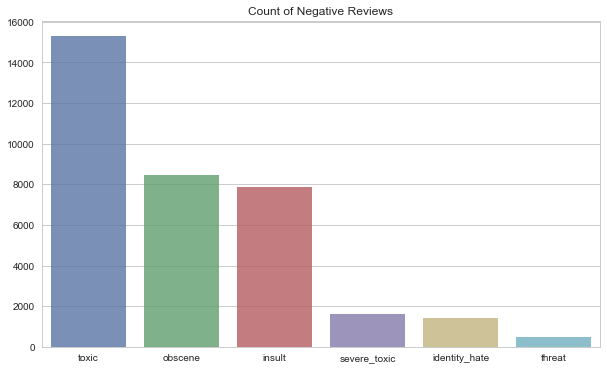

In [32]:
#count negative comments 
sentSum = trainDF[trainDF.columns[2:8]].sum().sort_values(ascending = False)

plt.figure(figsize = (10,6))
sns.set(style="whitegrid")
sns.barplot(sentSum.index, sentSum.values, alpha = 0.8).set_title('Count of Negative Reviews')
plt.show()


In [33]:
sentList = trainDF.columns[2:8]
per_sent = pd.DataFrame(sentSum / len(trainDF[sentList]), columns = ['Percentage'])

sentSum = pd.DataFrame(data = sentSum, columns = ['Sentiment_Count'])
sentSum['percentage'] = per_sent
sentSum

,Sentiment_Count,percentage
toxic,15294,0.095844
obscene,8449,0.052948
insult,7877,0.049364
severe_toxic,1595,0.009996
identity_hate,1405,0.008805
threat,478,0.002996


### Do comments have more than one sentiments?
Most of the comments have just one sentiment, but still many comments have more than one sentiments. Comments with multi-sentiments usually have three sentiments or two sentiments. However, in some extreme cases, comments can have six sentiments in a single comment.

   multiSent
1       6360
3       4209
2       3480
4       1760
5        385
6         31


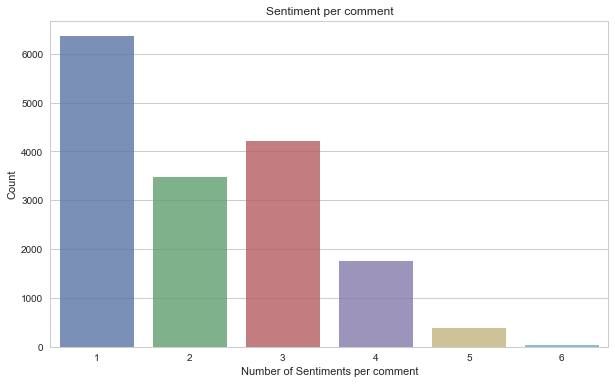

In [36]:
#Count if comments have more than one sentiments?
trainDF['multiSent'] = trainDF[sentList].sum(axis = 1)
multisent = pd.DataFrame(trainDF.multiSent.value_counts())
print(multisent[1:7])

plt.figure(figsize = (10,6))
g = sns.barplot(multisent.index[1:7], multisent.multiSent[1:7], alpha = 0.8).set_title('Sentiment per comment')
plt.xlabel('Number of Sentiments per comment')
plt.ylabel('Count')
plt.show()


**Select comments that are 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'**


In [39]:
def sentimentText(data, sent):
        sentDF = data[['comment_text',sent]]
        sentDF = sentDF[(sentDF[sent] == 1)]
        sentDF = pd.DataFrame(sentDF['comment_text'])
        sentDF = sentDF['comment_text']
        return sentDF
    

In [40]:
toxicText = sentimentText(trainDF, 'toxic')
severe_toxic_text = sentimentText(trainDF, 'severe_toxic')
obsceneText = sentimentText(trainDF, 'obscene')
threatText = sentimentText(trainDF, 'threat')
insultText = sentimentText(trainDF, 'insult')
identityHate_text = sentimentText(trainDF, 'identity_hate')    

# Preprocessing Text Comments

Comments contains punctuations, stopwords and stemmers that needs to be removed before using **Tf-idf (Term frequency-inverse document frequency)**. "Term frequency (Tf) measures the frequency of a word appears in a document. IDF (Inverse Document Frequency) measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance." source from http://www.tfidf.com/

- **TF(t)** = (Number of times term t appears in a document) / (Total number of terms in the document).
- **IDF(t)** = log_e(Total number of documents / Number of documents with term t in it).
- **Tf-idf weight** = TF(t) * IDF(t)

**Text cleaning process:**

- Tokenize comments
- Remove punctuations
- Remove stopwords in English
- Remove stemmers

**Visualize Tf-idf weight and count word frequencies using word cloud**

- Plot top 25 featured words based on Tf-idf weight score on each toxicity
- Present word frequency on each toxicity using word cloud

### Cleaning Text

In [42]:
def cleanedTrain(df):
    
    ''' Tokenize comments '''
    tokenized_docs = [word_tokenize(doc) for doc in df]
    
    ''' Remove punctuations '''
    regex = re.compile('[%s]' % re.escape(string.punctuation)) #see documentation here: http://docs.python.org/2/library/string.html
    
    tokenized_docs_no_punctuation = []
    
    for review in tokenized_docs:
        
        new_review = []
        for token in review: 
            new_token = regex.sub(u'', token)
            if not new_token == u'':
                new_review.append(new_token)
    
        tokenized_docs_no_punctuation.append(new_review)
    
    ''' Remove stop words in English '''
    tokenized_docs_no_stopwords = []
    for doc in tokenized_docs_no_punctuation:
        new_term_vector = []
        for word in doc:
            if not word in stopwords.words('english'):
                new_term_vector.append(word)
        tokenized_docs_no_stopwords.append(new_term_vector)

    ''' Remove stemmer '''
    snowball = SnowballStemmer('english')

    preprocessed_docs = []

    for doc in tokenized_docs_no_stopwords:
        final_doc = []
        for word in doc:
            final_doc.append(snowball.stem(word))
        preprocessed_docs.append(final_doc)
    
    ''' Concatenate tokenized words ''' 
    for j in range(len(preprocessed_docs)):
        preprocessed_docs[j] = "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in preprocessed_docs[j]]).strip()
    
    return preprocessed_docs


In [50]:
toxicClean = cleanedTrain(toxicText)
severe_toxic_clean = cleanedTrain(severe_toxic_text)
obsceneClean = cleanedTrain(obsceneText)
threatClean = cleanedTrain(threatText)
insultClean = cleanedTrain(insultText)
identity_hate_clean = cleanedTrain(identityHate_text)


### Find Top Featured Words Based on Tf-idf Weight Score

In [51]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    dff = pd.DataFrame(top_feats)
    dff.columns = ['feature', 'tfidf']
    return dff


def top_overall_words(text, features, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in ids. '''
    D = text
    D[D < min_tfidf] = 0 # so common words across all documents won't dominate - may remove
    tfidf_mean = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_mean, features, top_n)


def tfidf_generator(lem_comb):
    tfidf = TfidfVectorizer(ngram_range=(1,2),
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1,stop_words = 'english')
    text_tfidf = tfidf.fit_transform(lem_comb)
    dense_text = text_tfidf.todense()
    dense_text2 = np.squeeze(np.asarray(dense_text))
    features = tfidf.get_feature_names()
    return top_overall_words(dense_text2, features)


In [57]:
top25_toxic = tfidf_generator(toxicClean)
top25_severeToxic = tfidf_generator(severe_toxic_clean)
top25_obscene = tfidf_generator(obsceneClean)
top25_treat = tfidf_generator(threatClean)
top25_insult = tfidf_generator(insultClean)
top25_identityHate = tfidf_generator(identity_hate_clean)

### Visualize Tf-idf Score & Word Frequencies on Each Sentiment

In [114]:
from wordcloud import WordCloud, STOPWORDS

#Store comments of each sentiment
all_negative = [toxicClean, severe_toxic_clean, obsceneClean, threatClean, insultClean, identity_hate_clean]
all_negative = [pd.DataFrame(data = all_negative[n], columns = ['comment_text']) for n in range(6)]


In [113]:
def tfidf_plot(toPlot, title):
    
    ''' Plot out Tf-idf score '''
    fig, ax = plt.subplots(figsize = (8,6))
    toPlot.sort_values(by = 'tfidf', ascending=True).plot.barh(x ='feature', ax = ax)
    ax.set(title = title)
    plt.show()
    

In [115]:
def wordcloud_sent(negative_words, title1):
    
        ''' Plot out word cloud of each sentiment '''
        plt.figure(figsize = (10,8))
        plt.title(title1)
        wordcloud = WordCloud(font_path = '/.../CabinSketch-Bold.ttf',
                              stopwords = STOPWORDS,
                              background_color = 'white').generate(str(negative_words.comment_text))

        plt.imshow(wordcloud)
        plt.axis('off')
        plt.show()
        

#### Toxic Comments: Tf-idf score plot & Word Cloud 
- Top words based on Tf-idf score are:
**_fuck, suck, nt, shit, bitch, page, like, block, stop, wikipedia, stupid, edit, ass_**

- Word Cloud Word Frequency:
**_fuck, delet, shit, ass, edit, think_**

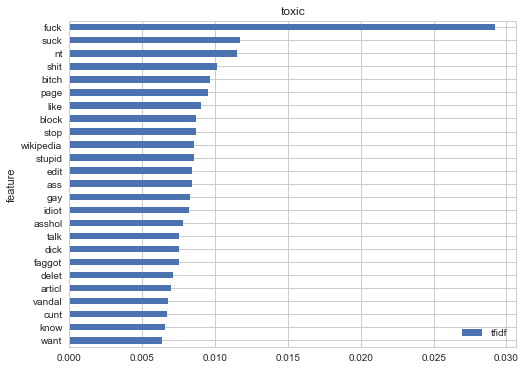

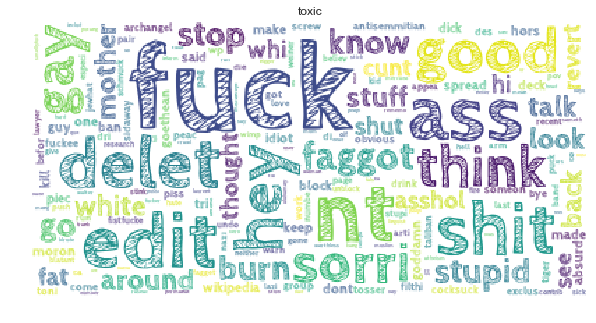

In [116]:
tfidf_plot(top25_toxic, 'toxic')
wordcloud_sent(all_negative[0], 'toxic')


#### Severe Toxic Comments: Tf-idf score plot & Word Cloud
- Top words based on Tf-idf score are:
**_fuck, suck, bitch, shit, fuck fuck, asshol, dick, ass, cunt, faggot, nt, cock, gay_**

- Word Cloud Word Frequency:
**_fuck, bitch, stupid, motherfuck, faggot, shit_**

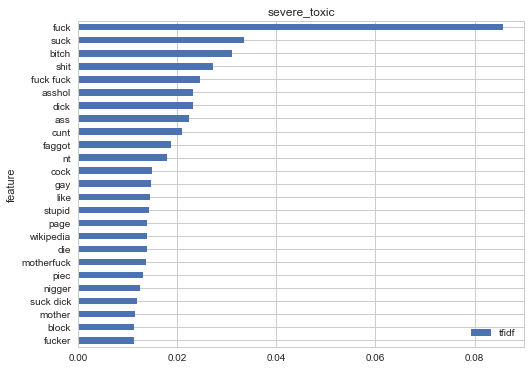

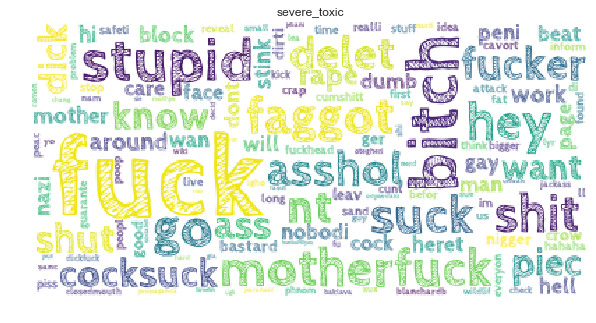

In [117]:
tfidf_plot(top25_severeToxic, 'severe_toxic')
wordcloud_sent(all_negative[1], 'severe_toxic')


#### Obscene Comments: Tf-idf score plot & Word Cloud
- Top words based on Tf-idf score are:
**_fuck, suck, bitch, shit, nt, asshol, ass, dick, cunt, faggot, like, page, stupid_**

- Word Cloud Word Frequency:
**_fuck, shit, ass, faggot, bitch, delete_**

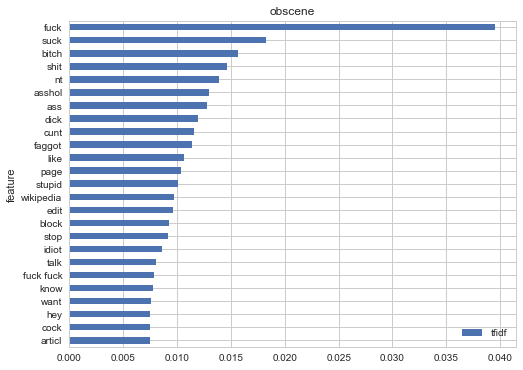

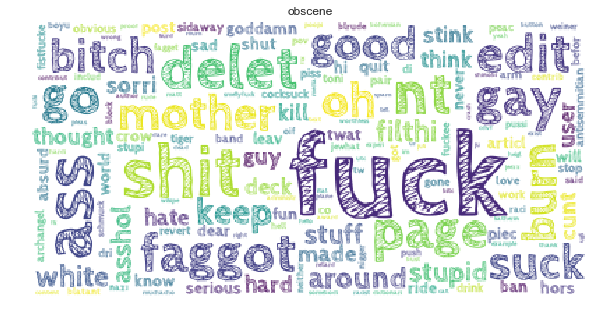

In [118]:
tfidf_plot(top25_obscene, 'obscene')
wordcloud_sent(all_negative[2], 'obscene')


#### Threat Comments: Tf-idf score plot & Word Cloud
- Top words based on Tf-idf score are:
**_die, kill, fuck, nt, hope, ass, death, shit, rape, like, edit, know, page_**

- Word Cloud Word Frequency:
**_die, fuck, kill, go, stop, bitch_**

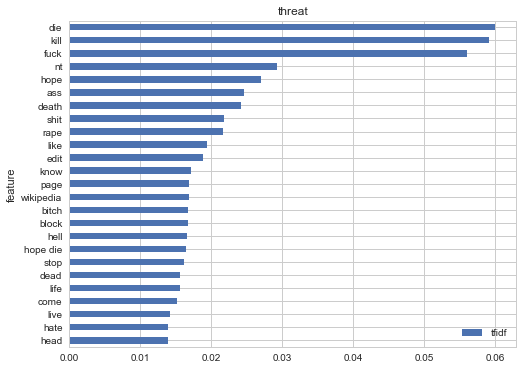

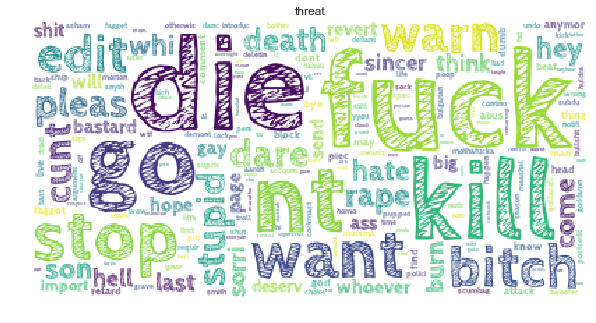

In [120]:
tfidf_plot(top25_treat, 'threat')
wordcloud_sent(all_negative[3], 'threat')


#### Insult Comments: Tf-idf score plot & Word Cloud
- Top words based on Tf-idf score are:
**_fuck, suck, bitch, nt, shit, idiot, asshol, faggot, stupid, ass, like, cunt, dick_**

- Word Cloud Word Frequency:
**_fuck, ass, faggot, shit, delete, shut_**

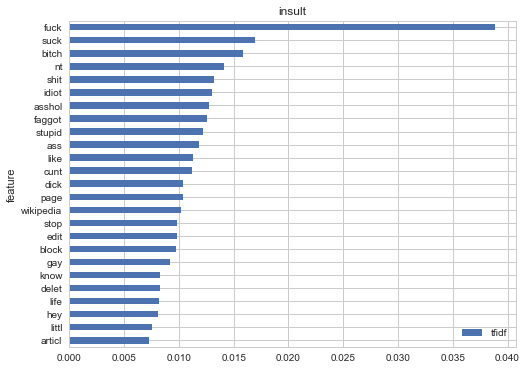

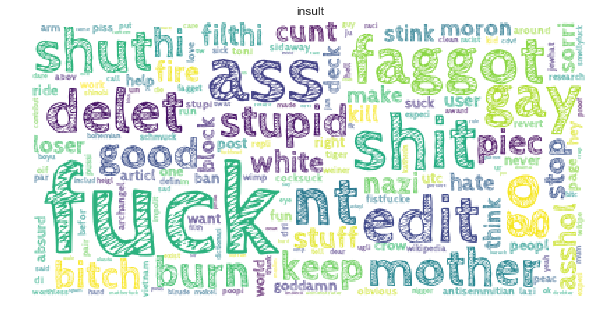

In [121]:
tfidf_plot(top25_insult, 'insult')
wordcloud_sent(all_negative[4], 'insult')


#### Identity Hate Comments: Tf-idf score plot & Word Cloud
- Top words based on Tf-idf score are:
**_fuck, gay, faggot, nigger, like, shit, jew, nt, bitch, ass, suck, stupid, homosexu_**

- Word Cloud Word Frequency:
**_fuck, gay, faggot, stupid, bitch, ass_**

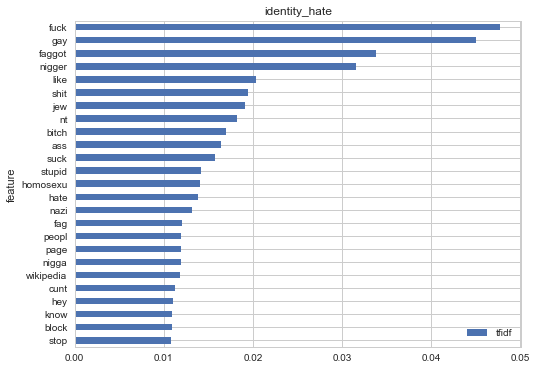

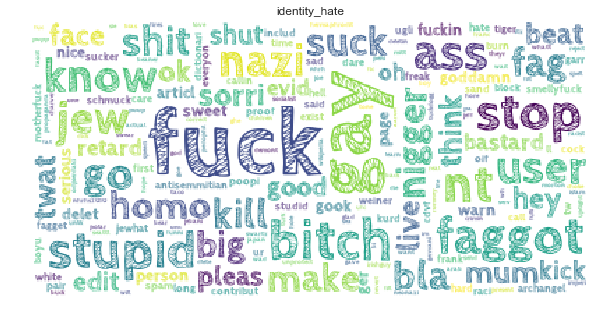

In [122]:
tfidf_plot(top25_identityHate, 'identity_hate')
wordcloud_sent(all_negative[5], 'identity_hate')


# Text Classification 

### Logistic Regression

Before parameter selection
- Split training & test data from training data set with 80% training size and 20% test size.
- Implement Logistic Regression for toxicity comment classification.
- Check the training score and test score to see if there is overfitting on the training data.

After parameter selection
- Use the training data set as training data to predict probability of toxicity comment on test data set.
- Implement Logistic Regression model with optimal regularization C on training data.
- Return probability estimate of each toxicity on each comment on the test data.

### Regularization Parameter Selection
- Grid Search Cross Validation: Tune parameters using Grid Search CV to find the optimal regularization C
- Smaller C indicates stronger regularization, and larger C means less regularization and constrains the model less.

### Probability of Different Types of Toxicity
- Return probability estimate of different types of toxicity on the test data.
- Generate a toxicity classification probability report of 6 types of toxicity in the correct format.


In [136]:
# Preprocessing all the text comments(All sentiments, including neutral comments)
totalClean_df = cleanedTrain(trainTest.comment_text) #Clean comments using previously built function - cleanedTrain
word = trainDF[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
totalClean_df.shape


(312735, 2)

In [130]:
#Training data & test data
train_all = totalClean_df.iloc[:159571] 
test_all = totalClean_df.iloc[159571:] 

print(train_all.shape, test_all.shape)

(159571, 2) (153164, 2)


In [134]:
#Select sentiments
word = trainDF[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]

#Final training data set 
train_final = pd.concat([train_all, word], axis=1)
train_final.head()


,comment_text,final,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,explan whi edit made usernam hardcor metallica...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,daww he match background colour i seem stuck t...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",hey man i realli tri edit war it guy constant ...,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",more i ca nt make real suggest improv i wonder...,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",you sir hero ani chanc rememb page,0,0,0,0,0,0


#### Apply Tf-idf to the Training Data & Test Data

In [139]:
vec = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9, strip_accents='unicode', 
                      use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words = 'english')

trn_term_doc = vec.fit_transform(train_all['final'].values.astype('U'))
test_term_doc = vec.transform(test_all['final'].values.astype('U'))


## Logistic Regression

- Not using grid search for parameter selection on Logistic Regression at this point.
- Split training & test data from training data set with 80% training size and 20% test size.


In [144]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [147]:
def logistic_no_GridSearch(lg):
    
    #Split training & test data
    x = trn_term_doc
    y_sent = lg
    x_train, x_test, y_train, y_test = train_test_split(x, y_sent, test_size = 0.2, random_state = 10)

    #Logistic Regression without using Grid Search
    logit = linear_model.LogisticRegression()
    logit.set_params(C = 1e4)
    logit.fit(x_train, y_train)
    print('Training accuracy: ', logit.score(x_train, y_train))
    print('Test accuracy    : ', logit.score(x_test, y_test))
    return logit, x_train, x_test, y_train, y_test
    

### Evaluation of Training & Test Score
- Based on the training and test score, overfitting might take the place since there's 0.4 difference between training score and test score. 
- Tuning parameter with regularization can avoid overfitting problem.
- Except Toxic comments, other toxicity comments do not have overfitting issue, but we can still tune the parameter to increase the model accuracy. 

In [148]:
# Accuracy (no GridSearch) - Toxic Comments 
logit_toxic, x_trainToxic, x_testToxic, y_trainToxic, y_testToxic = logistic_no_GridSearch(train_final.toxic)

Training accuracy:  0.999294980259
Test accuracy    :  0.952436158546


In [160]:
# Accuracy (no GridSearch) - Severe Toxic Comments 
logit_severe_toxic, x_trainSevereToxic, x_testSevereToxic, y_trainSevereToxic, y_testSevereToxic = logistic_no_GridSearch(train_final.severe_toxic)

Training accuracy:  0.999388982892
Test accuracy    :  0.987686041047


In [161]:
# Accuracy (no GridSearch) - Obscene Comments 
logit_obscene, x_trainObscene, x_testObscene, y_trainObscene, y_testObscene = logistic_no_GridSearch(train_final.obscene)

Training accuracy:  0.999420317102
Test accuracy    :  0.975528748238


In [162]:
# Accuracy (no GridSearch) - Threat Comments 
logit_threat, x_trainThreat, x_testThreat, y_trainThreat, y_testThreat = logistic_no_GridSearch(train_final.threat)

Training accuracy:  0.999921664473
Test accuracy    :  0.996772677424


In [163]:
# Accuracy (no GridSearch) - Insult Comments 
logit_insult, x_trainInsult, x_testInsult, y_trainInsult, y_testInsult = logistic_no_GridSearch(train_final.insult)

Training accuracy:  0.999106974995
Test accuracy    :  0.96023813254


In [164]:
# Accuracy (no GridSearch) - Identity Hate Comments 
logit_identityHate, x_trainIdentityHate, x_testIdentityHate, y_trainIdentityHate, y_testIdentityHate = logistic_no_GridSearch(train_final.identity_hate)

Training accuracy:  0.999772826972
Test accuracy    :  0.991007363309


## Regularization Parameter Selection
- Grid Search: Using grid search k-fold cross validation in order to reduce overfitting issue by setting the optimal regularization parameter C. 
- C is the inverse of regularization strength, smaller C indicates stronger regularization, and larger C means less regularization and constrains the model less.

**Grid Search**

In [153]:
def gridSearch(search, x_train_search, y_train_search, x_test_search, y_test_search):
    
    grid_para_log = [{
                      'C': [1, 10, 100, 1000, 10000]
                      }]
    grid_search_log = GridSearchCV(search, grid_para_log, 
                                   scoring = 'accuracy', 
                                   cv = 5, n_jobs = -1)
    %time grid_search_log.fit(x_train_search, y_train_search.values.ravel())
    print('Best parameter: ', grid_search_log.best_params_)
    print('Training score: ', grid_search_log.score(x_train_search, y_train_search))
    print('Test score    : ', grid_search_log.score(x_test_search, y_test_search))
 

### Best parameter & Score
The followings are the best parameter C for logistic regression and training & test score on each toxicity. 
- With regularization tuning parameter C, we can reduce overfitting problem by minimizing variances in the training data and thus increase accuracy. 
- Based on the score after parameter selection, accuracy increased up to 99% and the differences between training score and test score are minimized. 

In [154]:
#Toxic comments
gridSearch(logit_toxic, x_trainToxic, y_trainToxic, x_testToxic, y_testToxic)

CPU times: user 10.4 s, sys: 2.98 s, total: 13.3 s
Wall time: 3min 38s
Best parameter:  {'C': 10}
Training score:  0.961679461068
Test score    :  0.992205615091


In [165]:
# Severe Toxic Comments
gridSearch(logit_severe_toxic, x_trainSevereToxic, y_trainSevereToxic, x_testSevereToxic, y_testSevereToxic)

CPU times: user 8.06 s, sys: 2.78 s, total: 10.8 s
Wall time: 4min 24s
Best parameter:  {'C': 1}
Training score:  0.991195362682
Test score    :  0.990975747321


In [166]:
# Obscene Comments
gridSearch(logit_obscene, x_trainObscene, y_trainObscene, x_testObscene, y_testObscene)

CPU times: user 9.34 s, sys: 1.71 s, total: 11 s
Wall time: 3min 18s
Best parameter:  {'C': 10}
Training score:  0.979539401535
Test score    :  0.99513536379


In [167]:
# Threat Comments
gridSearch(logit_threat, x_trainThreat, y_trainThreat, x_testThreat, y_testThreat)

CPU times: user 11.9 s, sys: 1.43 s, total: 13.3 s
Wall time: 1min 58s
Best parameter:  {'C': 100}
Training score:  0.996804010653
Test score    :  0.999905997368


In [168]:
# Insult Comments
gridSearch(logit_insult, x_trainInsult, y_trainInsult, x_testInsult, y_testInsult)

CPU times: user 11.5 s, sys: 2.08 s, total: 13.6 s
Wall time: 5min 32s
Best parameter:  {'C': 10}
Training score:  0.969575434749
Test score    :  0.993122140753


In [169]:
# Identity Hate Comments
gridSearch(logit_identityHate, x_trainIdentityHate, y_trainIdentityHate, x_testIdentityHate, y_testIdentityHate)

CPU times: user 9.61 s, sys: 1.72 s, total: 11.3 s
Wall time: 2min 59s
Best parameter:  {'C': 10}
Training score:  0.992448691838
Test score    :  0.997501096697


## Probability of Different Types of Toxicity on Each Comment
- Apply Logistic Regression model with tuned parameter C on training data.
- Return probability estimate of each toxicity on each comment on the test data.
- Generate a toxicity classification probability report of 6 types of toxicity in the correct format. 

### Logistic Regression with Best Parameter based on Grid Search

In [175]:
def logistic_with_GridSearch(lg_search, c, y_grid, nonT, T):
    
    ''' Use all training data to predict test data '''
    lg_search.set_params(C = c, dual = True, fit_intercept = True)
    lg_search.fit(trn_term_doc, y_grid)    
    prob = lg_search.predict_proba(test_term_doc)
    prob = pd.DataFrame(prob, columns = [nonT, T])
    del prob[nonT]
    print(prob.head(10))
    return prob


In [176]:
#Probability estimate of Toxic comments
toxicProb = logistic_with_GridSearch(logit_toxic, 10, train_final.toxic, 'non-toxic', 'toxic')

      toxic
0  0.999996
1  0.000403
2  0.008551
3  0.002222
4  0.009593
5  0.009839
6  0.001470
7  0.621998
8  0.016335
9  0.003733


In [177]:
#Probability estimate of Severe Toxic comments
severe_toxic_Prob = logistic_with_GridSearch(logit_severe_toxic, 1, train_final.severe_toxic, 'non-severeToxic', 'severe_toxic')

   severe_toxic
0      0.257352
1      0.003056
2      0.003531
3      0.002279
4      0.001466
5      0.002185
6      0.001409
7      0.005624
8      0.003229
9      0.001996


In [178]:
#Probability estimate of Obscene comments
obsceneProb = logistic_with_GridSearch(logit_obscene, 10, train_final.obscene, 'non-obscene', 'obscene')

    obscene
0  0.999971
1  0.000344
2  0.003237
3  0.000942
4  0.004328
5  0.001235
6  0.002105
7  0.014733
8  0.004976
9  0.001359


In [179]:
#Probability estimate of Threat comments
threatProb = logistic_with_GridSearch(logit_threat, 100, train_final.threat, 'non-threat', 'threat')

     threat
0  0.014194
1  0.000075
2  0.000017
3  0.000032
4  0.000035
5  0.000067
6  0.000004
7  0.000535
8  0.000100
9  0.000029


In [180]:
#Probability estimate of Insult comments
insultProb = logistic_with_GridSearch(logit_insult, 10, train_final.insult, 'non-insult', 'insult')

     insult
0  0.995632
1  0.001524
2  0.003901
3  0.001290
4  0.004717
5  0.002481
6  0.002300
7  0.055296
8  0.005514
9  0.002150


In [181]:
#Probability estimate of Identity Hate comments
identityHate_Prob = logistic_with_GridSearch(logit_identityHate, 10, train_final.identity_hate, 'non-identityHate', 'identity_hate')

   identity_hate
0       0.683605
1       0.000548
2       0.000542
3       0.000168
4       0.000485
5       0.000323
6       0.000760
7       0.006052
8       0.000610
9       0.000408


#### Combine Toxicity Classification Probability in Correct Format 

In [185]:
testID = testDF[['id']]

FINAL = pd.concat([testID, toxicProb, severe_toxic_Prob, obsceneProb, threatProb, insultProb, identityHate_Prob], axis = 1)
FINAL.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999996,0.257352,0.999971,0.014194,0.995632,0.683605
1,0000247867823ef7,0.000403,0.003056,0.000344,0.000075,0.001524,0.000548
2,00013b17ad220c46,0.008551,0.003531,0.003237,0.000017,0.003901,0.000542
3,00017563c3f7919a,0.002222,0.002279,0.000942,0.000032,0.001290,0.000168
4,00017695ad8997eb,0.009593,0.001466,0.004328,0.000035,0.004717,0.000485
5,0001ea8717f6de06,0.009839,0.002185,0.001235,0.000067,0.002481,0.000323
6,00024115d4cbde0f,0.001470,0.001409,0.002105,0.000004,0.002300,0.000760
7,000247e83dcc1211,0.621998,0.005624,0.014733,0.000535,0.055296,0.006052
8,00025358d4737918,0.016335,0.003229,0.004976,0.000100,0.005514,0.000610
9,00026d1092fe71cc,0.003733,0.001996,0.001359,0.000029,0.002150,0.000408
